In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel

%matplotlib inline

In [2]:
# model name
model_name = 'model-2b-lsrz2'

shuffle_clusters = False

# load the training data
data = DataModel('data-mtx-enough-top-6.npz', 
                 batch_size = 64, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

# randomly shuffle the training data
np.random.seed(888)
ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [4]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 54, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 6, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 6, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 384)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [6]:
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 100:
        return .0003
    elif epoch < 200:
        return .0001
    elif epoch < 280:
        return .00003
    elif epoch < 360:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [ ]:
#TRAINING

In [7]:
%%time
# start the training
ai.train(epochs=400, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

17443/17443 [==============================] - 73s 4ms/step - loss: 3.0041 - e_cluster_loss: 0.0303 - p_cluster_loss: 0.0777 - type_loss: 0.2839 - pos_x_loss: 3.8504e-04 - pos_y_loss: 0.0370 - pos_z_loss: 4.5528e-04 - energy_loss: 0.4031 - e_cluster__cluster_accuracy: 0.9576 - p_cluster__cluster_accuracy: 0.8923 - type__type_accuracy: 0.8794 - type__type_tp_rate: 0.8148

CPU times: user 3d 22h 46min 13s, sys: 15h 54min 38s, total: 4d 14h 40min 52s
Wall time: 3d 17h 47s


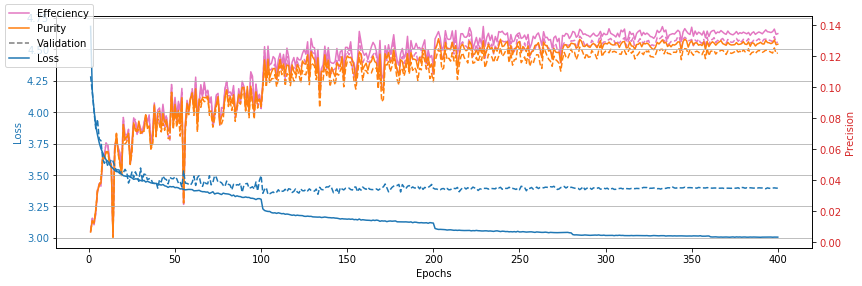

In [8]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [9]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        3.42126
    -Type:         0.28818 *  0.05 = 0.01441
    -Pos X:        0.00070 * 12.00 = 0.00844
    -Pos Y:        0.03808 *  2.00 = 0.07617
    -Pos Z:        0.00052 *  8.00 = 0.00413
    -Energy:       0.46162 *  7.00 = 3.23137
    -Cls e:        0.03397 *  0.15 = 0.00510
    -Cls p:        0.08168 *  0.10 = 0.00817
  Accuracy:    0.87633
    -TP rate:      0.81230
    -Cls e rate:   0.95384
    -Cls p rate:   0.88957
  Efficiency:  0.12728
  Purity:      0.12098
  Euc mean:   11.25084
  Euc std:    29.08063

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [10]:
# save the trained model
ai.save(file_name=model_name)